Привет! меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление</font>
* Спасибо за  качественную работу, мне она очень понравилась
- Я оставил некоторые советы надеюсь они будут полезными или интересными.
- Техника бутстрап применилась корректно, было проведено тщательное исследование.
- С радостью принимаю твою работу и желаю удачи в дальнейшем обучении.
- Продолжай в том же духе, у тебя большой потенциал)


# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

|признак|описание|что будем делать|
|--|--|--|
|id|уникальный идентификатор скважины|удалим, модели оно не поможет|
|f0, f1, f2|три признака точек|по факту `feautures`|
|product|объём запасов в скважине|целевой признак `target`|

## Загрузка и подготовка данных

### Подгрузка библиотек

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import cross_val_score
matplotlib.style.use('seaborn-pastel')
from numpy.random import RandomState 


<div class="alert alert-block alert-success">

<b>Успех:</b> Импорты и описание на месте
</div>



### Создание класса

In [9]:
class Region():
    def __init__(self, path, reg_number):
        self.path = path
        self.reg_number = reg_number
        self.read_csv_files(path)
        self.metrics = {}
        self.business_metrics = {
            'Бюджет' : 10_000_000_000,
            'Доход с ед.продукции' : 450_000,
            'Исследуемые скважины' : 500,
            'Потенциально разрабатываемые скважины' : 200           
        }
    
    def read_csv_files(self, path):
        try:
            self.df = pd.read_csv(path)
        except:
            self.df = pd.read_csv(f'/datasets/{path}')
            
    def print_separator(self, text):
        '''Ну просто вывести текст... лучше не вникать в код. по сути фигней старадаю'''
        len_txt = (80 - len(text)+2)//2
        final_txt = '\n'
        if len(text) % 2 == 1:
            final_txt += '-'
        for _ in range(len_txt):
            final_txt += '-'
        final_txt += f' {text} {self.reg_number} '
        for _ in range(len_txt):
            final_txt += '-'
        final_txt += '\n'
        print(final_txt)
        
    def learn_df(self):
        '''Метод который выводит основную информацию по первоначальному df
        '''
        self.print_separator('Регион')
        self.df.info()
        print()
        display(self.df.describe())
        self.print_separator('Распределение')
        self.df.hist(figsize=(14,7))
        plt.show()
        print()
        self.print_separator('Корреляция')
        fig, ax = plt.subplots(figsize=(5,5))
        sns.heatmap(self.df.corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax)
        plt.show()
        self.print_separator('Дубликаты')
        sum_duplicates = len(self.df[self.df.duplicated(subset=['id'])])
        print(f'Кол-во дубликатов: {sum_duplicates}')
        display(self.df[self.df.duplicated(subset=['id'], keep=False)].sort_values(by=['id']).head(4))
    
    def create_model_and_fit(self):
        '''Метод для создания модели LinearRegression. Также масштабирует признаки. 
        Выводит метрику R.M.S.E. а также средний предсказанный и фактический запас нефти 
        для предсказанных значений.(25% от ген.совокупности)
        '''
        self.df.drop(columns=['id'], inplace=True)
        self.features = self.df.drop(columns=['product']) 
        self.target = self.df['product']
        scaler = StandardScaler() # Масштабируем признаки
        scaler.fit(self.features)
        scaler.transform(self.features)
        self.fit_model() # Обучаем модель и делим на трениров/обучающие выборки
        self.print_separator('Регион')
        print(f'RMSE модели = {self.metrics["R.M.S.E"]:.2f}')
        print(f'Средний предсказанный запас сырья = {self.metrics["Предсказанный запас сырья"]:.2f}')
        print(f'Фактический средний запас сырья = {self.metrics["Фактический средний запас сырья"]:.2f}')
        
    def fit_model(self):
        '''Делит выборки на обучающие и тестовые(валидационные), подсчитывает основные метрики
        Обучает модель.
        '''
        self.features_train, self.features_valid, self.target_train, self.target_valid = \
            train_test_split(self.features, self.target, test_size=.25, random_state=333)
        self.model = LinearRegression()
        self.model.fit(self.features_train, self.target_train)
        self.predict = self.model.predict(self.features_valid)
        self.predict = pd.Series(self.predict, index=self.target_valid.index)
        self.metrics['R.M.S.E'] = math.sqrt(mean_squared_error(self.target_valid, self.predict))
        self.metrics['Предсказанный запас сырья'] = self.predict.mean()
        self.metrics['Фактический средний запас сырья'] = self.target_valid.mean()
        
    def calculate_profite(self):
        '''Подсчет основных бизнес метрик для 200 лучше всего спрогнозированных месторождений
        '''
        self.print_separator('Регион')
        self.predict_sort = self.predict.sort_values(ascending=False)[:200]
        self.sum_fact_oil = self.target_valid[self.predict_sort.index].sum()
        self.profit = self.sum_fact_oil * self.business_metrics['Доход с ед.продукции'] / 1_000_000_000 - 10
        print(f'Фактический запас нефти из 200 лучше всего спрогнозированных шахт: {self.sum_fact_oil:.2f}')
        print(f'Потенциальная прибыль: {self.profit:.2f} млрд. руб')

In [3]:
class Business_values():
    def __init__(self, region: Region):
        self.region = region
        self.revenues = [] # Series с прибылью
        self.state = RandomState(333)
        self.region.print_separator('Регион')
        self.bootstrap()

    def potencial_revenue(self, target: pd.Series, predict: pd. Series):
        '''Подсчитывает прибыль с переданной пары выборок(ц.признак известный/предсказанный)
        для лучших 200 предсказанных объектов
        Returns: float (прибыль в млрд.)
        '''
        predict_sorted = predict.sort_values(ascending=False)[:200]
        selected_target = target[predict_sorted.index]
        return (selected_target.sum() * self.region.business_metrics['Доход с ед.продукции'] - 10**10)/10**9
    
    def bootstrap(self):
        '''Методом bootstrap создает Series с потенциальной прибылью и выводит основные полученные метрики
        '''
        for _ in range(1000):
            target_subsample = self.region.target_valid.sample(n=500, replace=True, random_state=self.state)
            predict_subsample = self.region.predict[target_subsample.index]
            self.revenues.append(self.potencial_revenue(target=target_subsample, predict=predict_subsample))
        self.revenues = pd.Series(self.revenues)    
        
        print(f'Средняя прибыль: {self.revenues.mean():.2f} млрд.руб')
        print(f'2,5%-квантиль: {self.revenues.quantile(0.025):.2f} млрд.руб')
        print(f'97,5%-квантиль: {self.revenues.quantile(0.975):.2f} млрд.руб')
        print(f'Количество убыточных экспериментов: {len(self.revenues[self.revenues<0])}')
        print(f'Вероятность убытков: {(len(self.revenues[self.revenues<0])/len(self.revenues)):.1%}')


      

<div class="alert alert-block alert-success">

<b>Успех:</b> Отличные решение исопльзовать функции/класы и избежать дублирования кода
</div>



### Загрузка и изучение данных


-------------------------------------- Регион 0 --------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



----------------------------------- Распределение 0 ----------------------------------



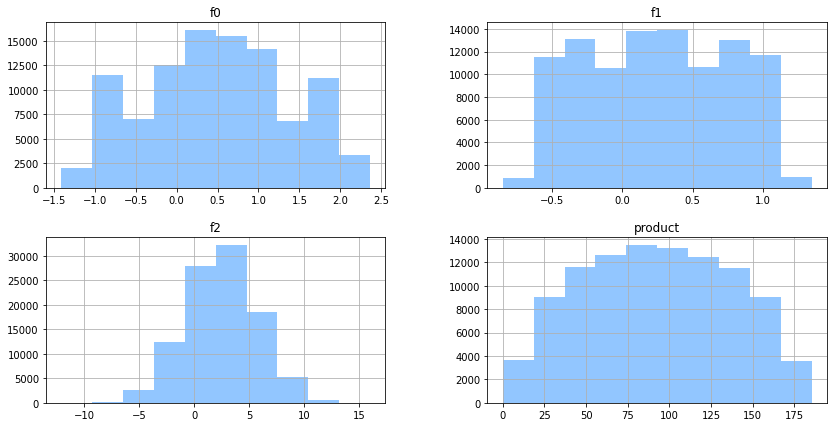



------------------------------------ Корреляция 0 ------------------------------------



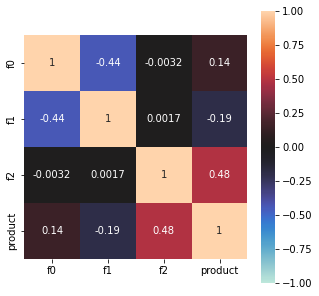


------------------------------------- Дубликаты 0 ------------------------------------

Кол-во дубликатов: 10


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364



-------------------------------------- Регион 1 --------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



----------------------------------- Распределение 1 ----------------------------------



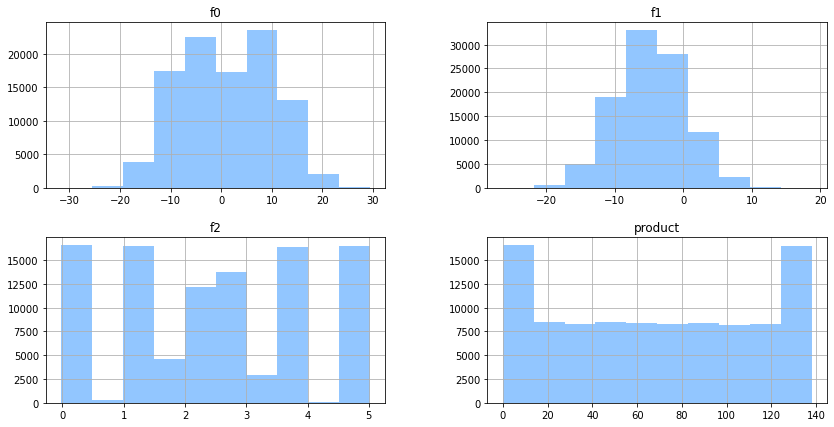



------------------------------------ Корреляция 1 ------------------------------------



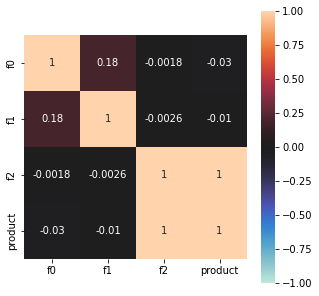


------------------------------------- Дубликаты 1 ------------------------------------

Кол-во дубликатов: 4


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625



-------------------------------------- Регион 2 --------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



----------------------------------- Распределение 2 ----------------------------------



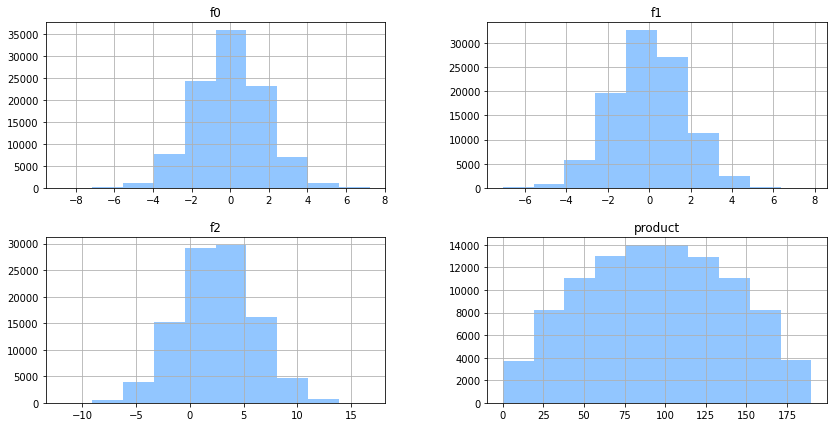



------------------------------------ Корреляция 2 ------------------------------------



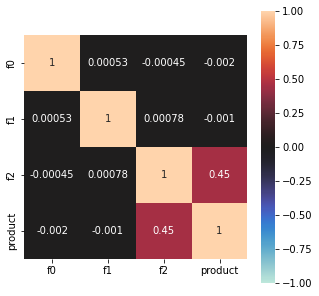


------------------------------------- Дубликаты 2 ------------------------------------

Кол-во дубликатов: 4


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


In [10]:
region_0 = Region('geo_data_0.csv', 0)
region_1 = Region('geo_data_1.csv', 1)
region_2 = Region('geo_data_2.csv', 2)
regions_list = [region_0, region_1, region_2]
for reg in regions_list:
    reg.learn_df()

Данные загружены и предварительно изучены.
- Есть дубликаты по `id` но при этом значения очень разнятся... удалять не буду.
- В регионе с нулевым и вторым индексами наблюдается нормальное распределение признаков и запасов сырья, чего нельзя сказать о втором регионе
- Очень интересно что зависимость третьего признака практически линейная с запасами нефти, даже модель не обязательно строить...

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные осмотрены корректно
    
  
</div>
<div class="alert alert-block alert-info">
<b>Совет </b>  Советую обратить внимание на библиотеки sweetviz и pandas_profiling помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям. 
    
Очень просты в использоовании, на вход кладется датафрейм: pandas_profiling.ProfileReport(df) <br> P.S. Советую пробовал локально, на платформе будут проблемы
    
</div>

## Обучение и проверка модели

In [5]:
for reg in regions_list:
    reg.create_model_and_fit()


-------------------------------------- Регион 0 --------------------------------------

RMSE модели = 37.60
Средний предсказанный запас сырья = 92.25
Фактический средний запас сырья = 92.52

-------------------------------------- Регион 1 --------------------------------------

RMSE модели = 0.88
Средний предсказанный запас сырья = 68.47
Фактический средний запас сырья = 68.46

-------------------------------------- Регион 2 --------------------------------------

RMSE модели = 39.84
Средний предсказанный запас сырья = 95.12
Фактический средний запас сырья = 95.14


- Есть подозрение что практически из-за линейной зависимости, во втором регионе ооочень хорошее качество предсказания.
- Интересно что предсказанный запас везде отличается менее чем на 1% по сравнению с фактическим.

<div class="alert alert-block alert-success">
<b>Успех:</b> Шаг проделан лаконично, все нужные метрики посчитаны корректно. 
</div>

## Подготовка к расчёту прибыли

In [6]:
sufficient_level_oil = (
    region_0.business_metrics['Бюджет'] / \
    region_0.business_metrics['Потенциально разрабатываемые скважины']) / \
    region_0.business_metrics['Доход с ед.продукции']
print(f'Необходимый запас нефти, для окупаемости скважины: {sufficient_level_oil:.2f} тыс. баррелей')
for reg in regions_list:
    print(f'Средний фактический запас нефти(на 1месторождение) в регионе {reg.reg_number}: {reg.df["product"].mean():.2f} тыс. баррелей')


Необходимый запас нефти, для окупаемости скважины: 111.11 тыс. баррелей
Средний фактический запас нефти(на 1месторождение) в регионе 0: 92.50 тыс. баррелей
Средний фактический запас нефти(на 1месторождение) в регионе 1: 68.83 тыс. баррелей
Средний фактический запас нефти(на 1месторождение) в регионе 2: 95.00 тыс. баррелей


In [7]:
for reg in regions_list:
    reg.calculate_profite()


-------------------------------------- Регион 0 --------------------------------------

Фактический запас нефти из 200 лучше всего спрогнозированных шахт: 29518.90
Потенциальная прибыль: 3.28 млрд. руб

-------------------------------------- Регион 1 --------------------------------------

Фактический запас нефти из 200 лучше всего спрогнозированных шахт: 27589.08
Потенциальная прибыль: 2.42 млрд. руб

-------------------------------------- Регион 2 --------------------------------------

Фактический запас нефти из 200 лучше всего спрогнозированных шахт: 27668.40
Потенциальная прибыль: 2.45 млрд. руб


На вид, примерно одинаковое распределение, необходимо провести стат. тесты

<div class="alert alert-block alert-success">
<b>Успех:</b> Значение для безубыточной разработки посчитано верно
  
</div>


## Расчёт прибыли и рисков 

In [8]:
for reg in regions_list:
    Business_values(reg)


-------------------------------------- Регион 0 --------------------------------------

Средняя прибыль: 0.62 млрд.руб
2,5%-квантиль: 0.02 млрд.руб
97,5%-квантиль: 1.24 млрд.руб
Количество убыточных экспериментов: 19
Вероятность убытков: 1.9%

-------------------------------------- Регион 1 --------------------------------------

Средняя прибыль: 0.64 млрд.руб
2,5%-квантиль: 0.15 млрд.руб
97,5%-квантиль: 1.16 млрд.руб
Количество убыточных экспериментов: 3
Вероятность убытков: 0.3%

-------------------------------------- Регион 2 --------------------------------------

Средняя прибыль: 0.56 млрд.руб
2,5%-квантиль: -0.04 млрд.руб
97,5%-квантиль: 1.17 млрд.руб
Количество убыточных экспериментов: 30
Вероятность убытков: 3.0%


<div class="alert alert-block alert-success">
<b>Успех:</b> С бутстрапом  все в порядке, все метрики считаются верным образом



### Вывод

- Не смотря на наименьшее запасов нефти, регион с индексом № 1 является более прибыльным, в первую очередь можно предположить, что это связано с высоким качеством предсказания модели.
- Также стоит отметить что, если удастся улучшить качество модели предсказания, то больший потенциал имеет регион № 0

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично! Проведено детальное исследование и был выбран правильный регион, поздравляю!
    
  
</div>


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован